### Задача исследования отделений Почта Банк

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
import math
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv('data.csv')

посмотрим на распределения данных

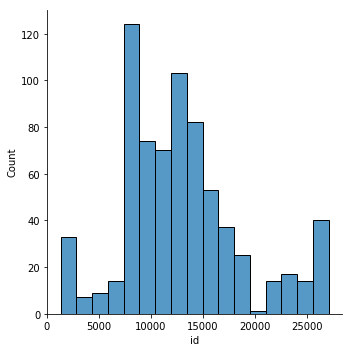

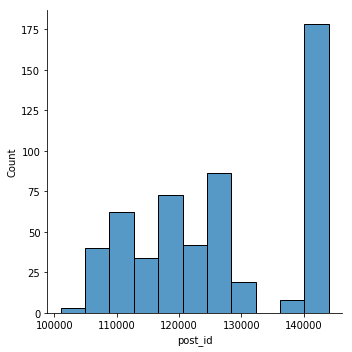

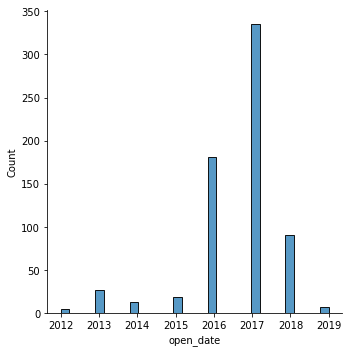

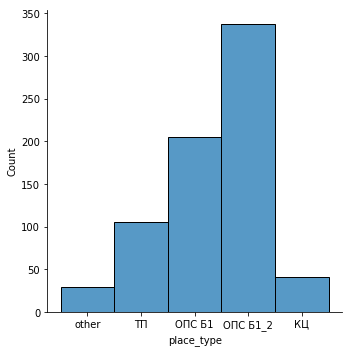

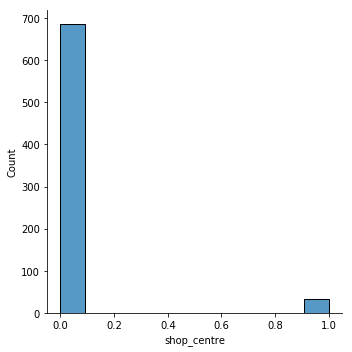

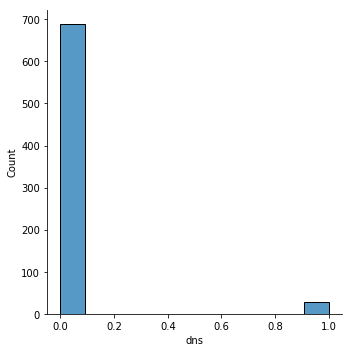

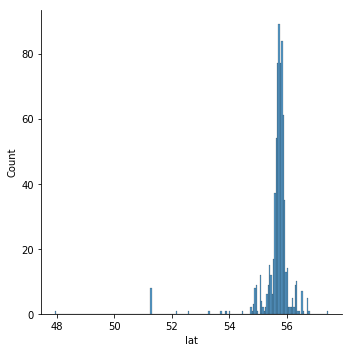

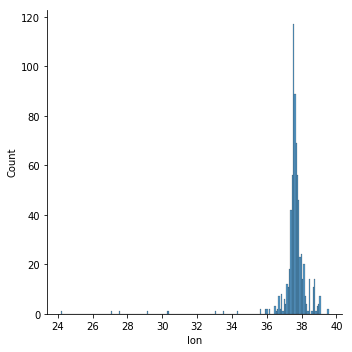

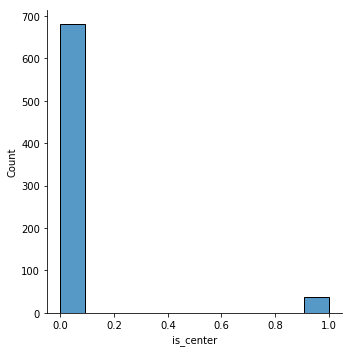

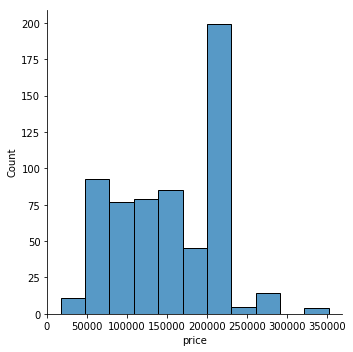

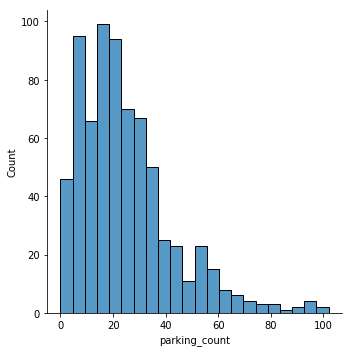

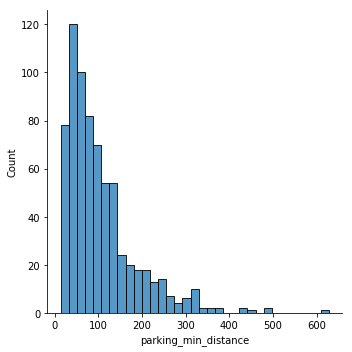

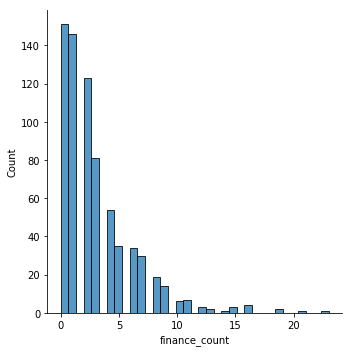

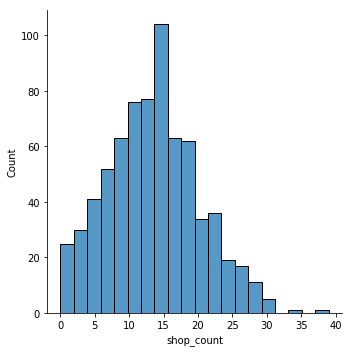

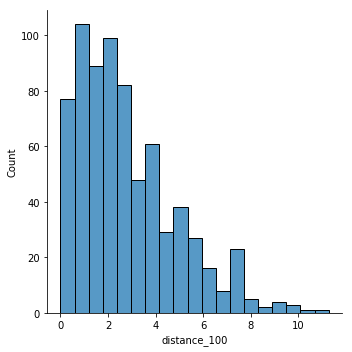

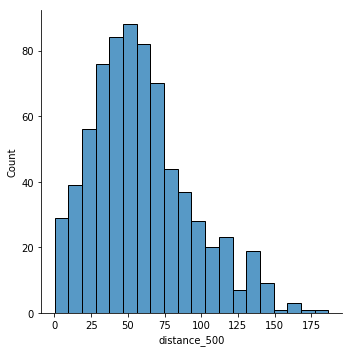

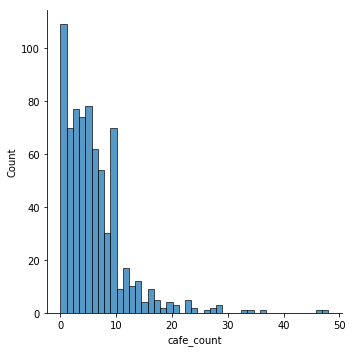

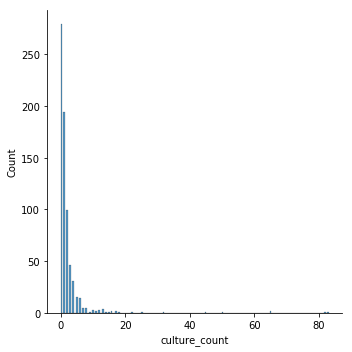

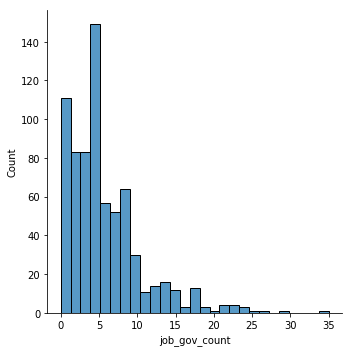

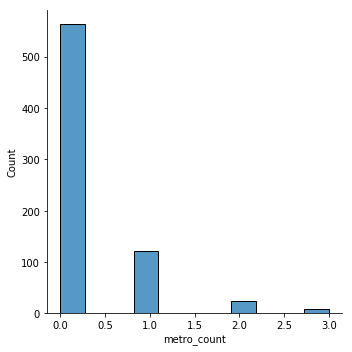

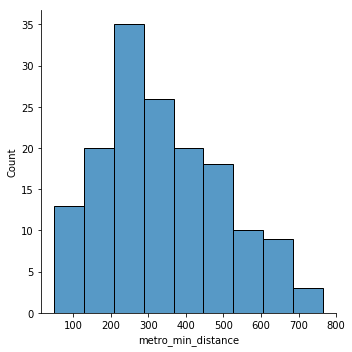

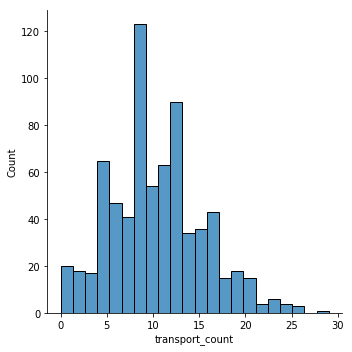

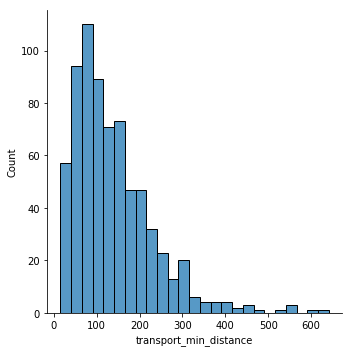

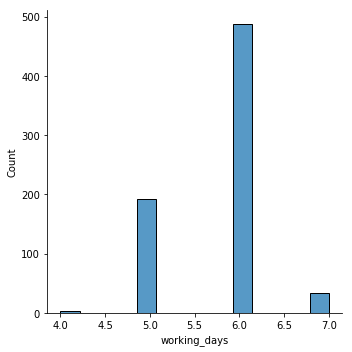

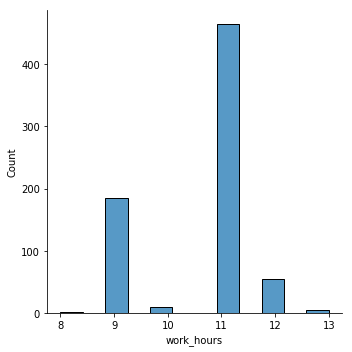

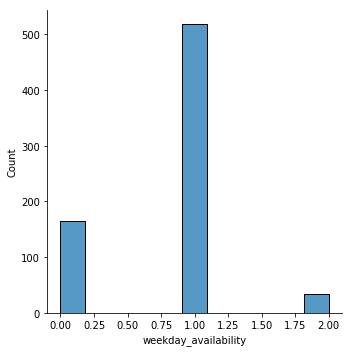

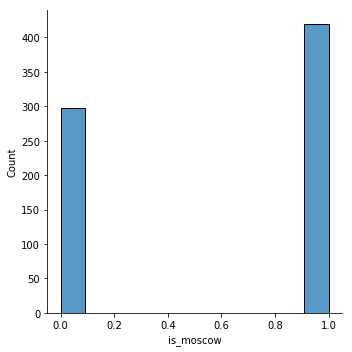

In [3]:
not_hist = ['street', 'address', 'response', 'district', 'office_hours', 'post2'] # большинство встречаются по одному разу
for i in df.columns.values:
    if (i not in not_hist):
        sns.displot(df, x=i)
        


Посмотрим на корреляцию

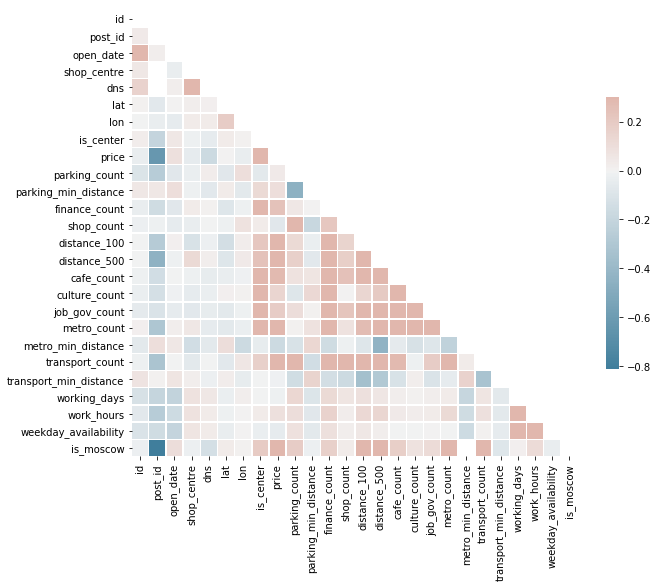

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


#### Предобработка данных


In [133]:
df_processed = df.copy()

###### Удаление признаков:
Удалим из признаков: response (дублирование информации с address), id, office_hours (хватает информации из других столбцов), 'street', 'address','district' - можно заменить lat и lon. 


In [134]:
dropped =  ['response', 'id', 'office_hours', 'street', 'address','district']
df_processed = df_processed.drop(dropped, axis = 1)

###### Обработка категориальных значений:

Категориальные признаки: 'place_type'

Закодируем с помощью one-hot encoging

In [135]:
categorical_columns =  ['place_type']
df_processed = df_processed.drop(categorical_columns, axis = 1)

In [136]:
dummies = pd.get_dummies(df[categorical_columns])
for i in dummies.columns.values:
    df_processed[i] = dummies[i]

Приведем post2  в нужный вид. Post_id и post2 - одно и то же, объединим их 

In [137]:
df_processed['post2'] = df_processed['post2'].str.extract(r'(\d{6})').replace(np.nan, '', regex=True)
#sns.displot(df_processed, x='post2')

In [138]:
post2 = df.loc[pd.isna(df.post_id)]['post2']
df_processed.loc[post2.index, 'post_id'] = post2
df_processed = df_processed.drop('post2', axis = 1)

###### Обработка пропущенных значений:

Заменим в metro_min distanse, 'transport_min_distance'  nan на 4000

In [139]:
fill_max_values = [ 'transport_min_distance', 'parking_min_distance', 'metro_min_distance']#'price',
for column in fill_max_values:
    df_processed[column] = df_processed[column].replace(np.nan, 4000, regex=True)

Заменим nan на среднее значение в столбцах: price(105)

In [140]:
fill_missing_values = ['price']

for column in fill_missing_values:
    mean_column = df_processed.loc[df_processed[column] > 0][column].mean()
    ids = df_processed.loc[pd.isna(df_processed[column])].index
    df_processed.loc[ids, column] = mean_column


#### Кластеризация

Используем Z-нормализацию

In [141]:
good_features = [ 'shop_centre', 'dns','shop_count', 'is_center','metro_count', 'place_type_КЦ',
                 'place_type_ОПС Б1', 'place_type_ОПС Б1_2', 'cafe_count', 'transport_count',
                 'job_gov_count','culture_count', 'place_type_ТП','finance_count', 'price','parking_min_distance', 
               'metro_min_distance', 'distance_500',  'distance_100','parking_count',
                  'transport_min_distance', 'working_days', 'work_hours','weekday_availability', 'is_moscow', 'place_type_other',
       ]

In [142]:
X = df_processed[good_features]
for feature in good_features:
    X[feature] = X[feature].astype(float)

In [143]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df_processed['label'] = kmeans.labels_

In [72]:
labels = df_processed.label.unique()
avg = []
med = []
moda = []

for label in labels:
    res = pd.DataFrame(columns = ['average', 'median', 'quantile_95', 'quantile_5'])
    print('\nlabel : ', label, ' мощность кластера: ', len(df_processed.loc[df_processed.label == label]))
    
    print('Средняя интенсивность человекопотока в окрестности 100 метров :', df_processed.loc[df_processed.label == label]['distance_100'].mean())
    print('Средняя интенсивность человекопотока в окрестности 500 метров :', df_processed.loc[df_processed.label == label]['distance_500'].mean())
    for column in good_features:
        res.loc[column, 'average'] = df_processed.loc[df_processed.label == label][column].mean()
        res.loc[column, 'median'] = df_processed.loc[df_processed.label == label][column].median()
        res.loc[column, 'quantile_95'] = df_processed.loc[df_processed.label == label][column].quantile(0.95)
        res.loc[column, 'quantile_5'] = df_processed.loc[df_processed.label == label][column].quantile(0.05)
        res.loc[column, 'min'] = df_processed.loc[df_processed.label == label][column].min()
        res.loc[column, 'max'] = df_processed.loc[df_processed.label == label][column].max()
    print(tabulate(res, headers='keys', tablefmt='psql'))


label :  1  мощность кластера:  154
Средняя интенсивность человекопотока в окрестности 100 метров : 4.034379406307976
Средняя интенсивность человекопотока в окрестности 500 метров : 94.13984693877546
+------------------------+----------------+-------------+---------------+---------------+---------------+-------------+
|                        |        average |      median |   quantile_95 |    quantile_5 |           min |         max |
|------------------------+----------------+-------------+---------------+---------------+---------------+-------------|
| shop_centre            |      0.0649351 |      0      |       1       |      0        |      0        |      1      |
| dns                    |      0.025974  |      0      |       0       |      0        |      0        |      1      |
| shop_count             |     14.8312    |     15      |      27       |      3        |      0        |     31      |
| is_center              |      0.162338  |      0      |       1       |      

+------------------------+---------------+-------------+---------------+----------------+---------------+------------+
|                        |       average |      median |   quantile_95 |     quantile_5 |           min |        max |
|------------------------+---------------+-------------+---------------+----------------+---------------+------------|
| shop_centre            |      0        |   0         |      0        |      0         |     0         |   0        |
| dns                    |      0        |   0         |      0        |      0         |     0         |   0        |
| shop_count             |      0.125    |   0         |      0.65     |      0         |     0         |   1        |
| is_center              |      0        |   0         |      0        |      0         |     0         |   0        |
| metro_count            |      0        |   0         |      0        |      0         |     0         |   0        |
| place_type_КЦ          |      0        |   0  

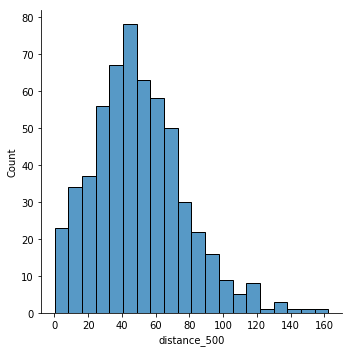

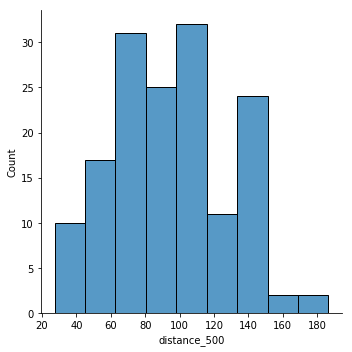

In [20]:
sns.displot(df_processed.loc[df_processed.label == 0], x='distance_500')
sns.displot(df_processed.loc[df_processed.label == 1], x='distance_500')

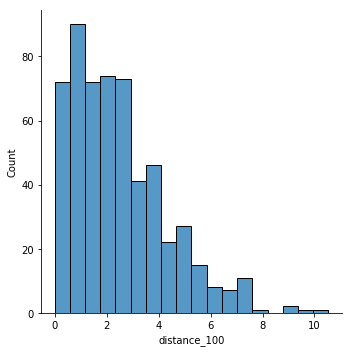

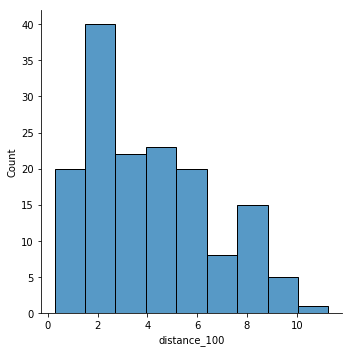

In [21]:
sns.displot(df_processed.loc[df_processed.label == 0], x='distance_100')
sns.displot(df_processed.loc[df_processed.label == 1], x='distance_100')

Аномалии

Определим аномальные отделы, как отделы, у которых более чем одна характеристика отличается от 98% остальных отделов


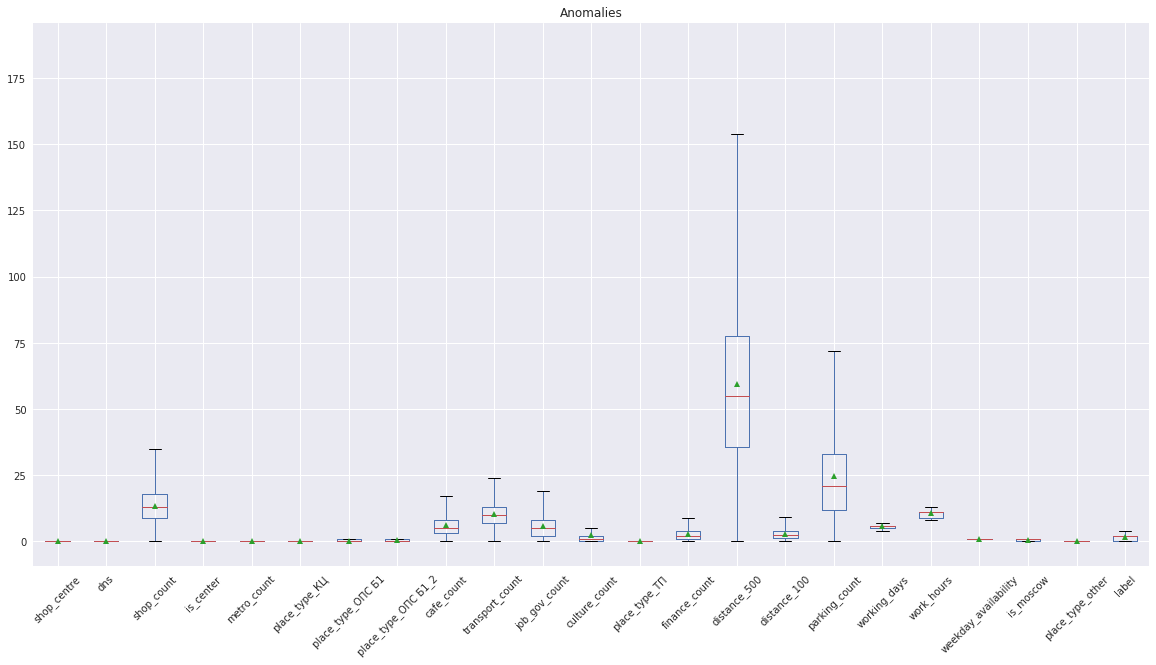

In [198]:
with plt.style.context(( "seaborn")):
    fig = plt.figure(figsize=(20,10))
    df_processed[good_features_label].boxplot(sym='o', whis=1.95, showmeans=True)
    plt.xticks(rotation=45)
    plt.title("Anomalies")

Выведем аномальные значения:

In [195]:
df_anomalies = df_processed[good_features].copy()
for i in good_features:
    
    a = df_anomalies[i] > df_processed[i].quantile(0.98) 
    b = df_anomalies[i] < df_processed[i].quantile(0.02)
    df_anomalies[i] = a | b
df_processed[good_features].loc[(df_anomalies.sum(axis = 1) > 1).values]

,shop_centre,dns,shop_count,is_center,metro_count,place_type_КЦ,place_type_ОПС Б1,place_type_ОПС Б1_2,cafe_count,transport_count,...,metro_min_distance,distance_500,distance_100,parking_count,transport_min_distance,working_days,work_hours,weekday_availability,is_moscow,place_type_other
2,False,False,15,False,1,0,0,0,12,23,...,434.931238,111.105429,11.275286,39,25.471714,6.0,11.0,1.0,True,0
15,False,False,0,False,0,0,1,0,0,6,...,4000.000000,0.116714,0.058000,0,153.288741,6.0,11.0,1.0,False,0
20,False,False,2,False,0,0,1,0,1,7,...,4000.000000,40.844857,0.142286,3,88.214511,6.0,11.0,1.0,False,0
23,False,False,39,False,0,0,1,0,4,10,...,4000.000000,70.916286,5.101714,69,37.178862,5.0,9.0,0.0,False,0
30,False,False,8,False,0,0,1,0,1,1,...,4000.000000,4.265714,0.700571,5,545.481041,5.0,9.0,0.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,False,False,0,False,0,0,0,0,0,1,...,4000.000000,0.083143,0.005286,0,641.105152,6.0,11.0,1.0,False,0
680,False,False,0,False,0,0,1,0,0,0,...,4000.000000,57.877000,3.862714,0,4000.000000,6.0,11.0,1.0,False,0
683,False,False,0,False,0,0,1,0,0,1,...,4000.000000,0.235857,0.056714,0,487.575642,6.0,11.0,1.0,False,0
688,False,False,1,False,0,0,1,0,1,10,...,4000.000000,3.375429,0.062714,0,262.544483,6.0,11.0,1.0,False,0


Выделим типичные точки - отделы в которых все значения находятся между 0.4 и 0.6 квантилем

In [200]:
df_anomalies = df_processed[good_features].copy()
for i in good_features:
    a = df_anomalies[i] > df_processed[i].quantile(0.4) 
    b = df_anomalies[i] < df_processed[i].quantile(0.6)
    df_anomalies[i] = a & b
df_processed[good_features].loc[(df_anomalies.sum(axis = 1) > 1).values]

,shop_centre,dns,shop_count,is_center,metro_count,place_type_КЦ,place_type_ОПС Б1,place_type_ОПС Б1_2,cafe_count,transport_count,...,metro_min_distance,distance_500,distance_100,parking_count,transport_min_distance,working_days,work_hours,weekday_availability,is_moscow,place_type_other
4,False,False,15,False,0,0,1,0,5,7,...,4000.0,23.848429,2.988571,21,164.255410,6.0,11.0,1.0,False,0
6,False,False,5,False,0,0,1,0,3,1,...,4000.0,19.461000,2.132857,2,131.351764,5.0,9.0,1.0,False,0
8,False,False,17,False,0,0,0,1,5,8,...,4000.0,32.025000,1.558143,15,97.014925,7.0,11.0,2.0,False,0
10,False,False,17,False,0,0,1,0,5,3,...,4000.0,54.174429,0.724286,12,172.381598,5.0,9.0,1.0,False,0
13,False,False,12,False,0,0,1,0,1,9,...,4000.0,26.887857,1.177857,22,250.650746,5.0,9.0,0.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,False,False,17,False,0,0,0,1,10,6,...,4000.0,56.192000,2.944714,22,37.051318,7.0,12.0,2.0,False,0
712,False,False,5,False,0,0,1,0,2,4,...,4000.0,34.336571,2.590714,5,56.183672,5.0,9.0,0.0,False,0
713,False,False,15,False,0,0,1,0,8,7,...,4000.0,73.631286,2.341857,25,144.747266,5.0,9.0,0.0,False,0
714,True,True,6,False,0,0,0,0,1,7,...,4000.0,47.120429,0.182143,20,123.172767,7.0,12.0,2.0,False,0


In [153]:


good_features_label = [ 'shop_centre', 'dns','shop_count', 'is_center','metro_count', 'place_type_КЦ',
                 'place_type_ОПС Б1', 'place_type_ОПС Б1_2', 'cafe_count', 'transport_count',
                 'job_gov_count','culture_count', 'place_type_ТП','finance_count', 
               'distance_500',  'distance_100','parking_count',
                  'working_days', 'work_hours','weekday_availability', 'is_moscow', 'place_type_other','label'
       ]
big_numbers = [ 'price','transport_min_distance', 'parking_min_distance', 'metro_min_distance', 'label']#